# Irish House Rent Prediction Project

This project is based on the **Irish Rent Dataset (Kaggle)**.  
The objective is to analyze rental price patterns and build a machine learning model to predict `rent_euro` using structured features from the dataset.

This notebook contains:
- Data loading
- Exploratory Data Analysis (EDA)
- Feature understanding
- Feature engineering
- Model training
- Model evaluation
- Model comparison


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Dataset Loading

The dataset is loaded from a CSV file containing structured housing rental data including:
- Time-based features
- Location features
- Property features
- Rent values (`rent_euro`)


In [2]:
data = pd.read_csv('irish_rent_full.csv')
data.head()

,rent_euro,year,half,half_year,time_period,county,province,area,location,property_type,bedrooms,bedrooms_num,is_dublin,is_city,is_county_aggregate
0,835.90,2020,1,2020H1,1,Carlow,Leinster,Carlow,Carlow,All property types,All bedrooms,NaN,False,False,True
1,860.74,2020,1,2020H1,1,Carlow,Leinster,Carlow Town,Carlow Town,All property types,All bedrooms,NaN,False,False,False
2,910.91,2020,1,2020H1,1,Carlow,Leinster,Graiguecullen,"Graiguecullen, Carlow",All property types,All bedrooms,NaN,False,False,False
3,812.14,2020,1,2020H1,1,Carlow,Leinster,Tullow,"Tullow, Carlow",All property types,All bedrooms,NaN,False,False,False
4,666.31,2020,1,2020H1,1,Cavan,Ulster,Cavan,Cavan,All property types,All bedrooms,NaN,False,False,True


## Exploratory Data Analysis (EDA)

In this section, rental price trends are analyzed using visualizations to understand:
- Year-wise rent trends
- Half-wise rent distribution
- Time-period based variations

These plots help in identifying patterns and seasonality in rental prices.


Text(0, 0.5, 'Rent in Euro')

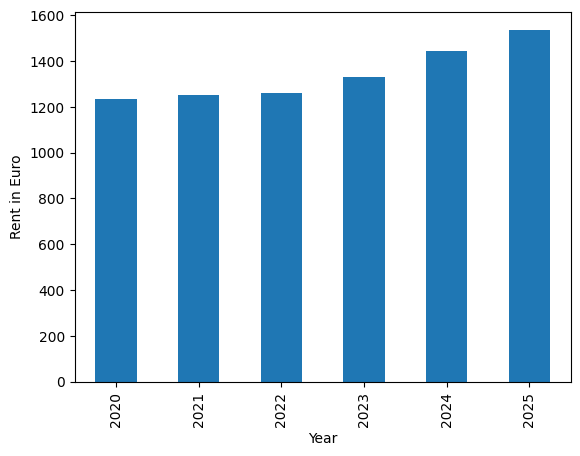

In [3]:
data.groupby('year')['rent_euro'].mean().sort_values(ascending = True).plot(kind = 'bar')
plt.xlabel('Year')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in Euro')

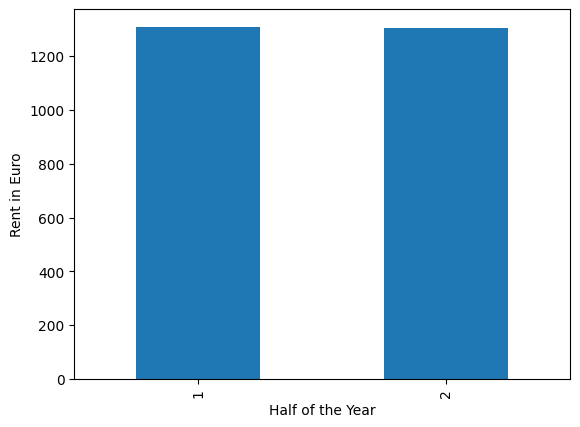

In [4]:
data.groupby('half')['rent_euro'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Half of the Year')
plt.ylabel('Rent in Euro')

## Feature Understanding

The dataset contains combined time features:
- `half_year` → combination of `year` + `half` (e.g. 2020H1)
- `time_period` → time-based segmentation

A constructed feature is created to verify and understand the structure of time variables.


In [5]:
data['constructed_half_year'] = (
    data['year'].astype(str) + 'H' + data['half'].astype(str)
)
match = (data['constructed_half_year'] == data['half_year']).mean()
match


np.float64(1.0)

Text(0, 0.5, 'Rent in Euro')

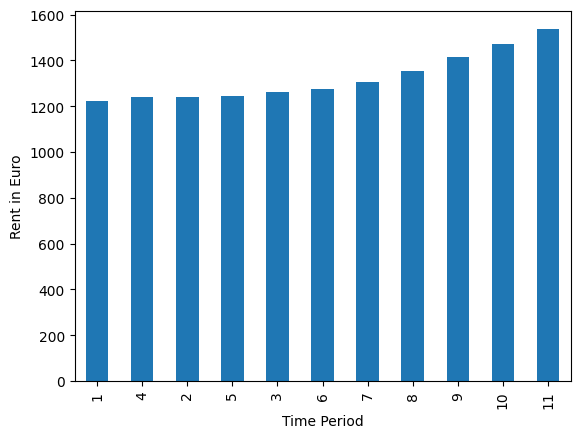

In [6]:
data.groupby('time_period')['rent_euro'].mean().sort_values(ascending = True).plot(kind = 'bar')
plt.xlabel('Time Period')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in Euro')

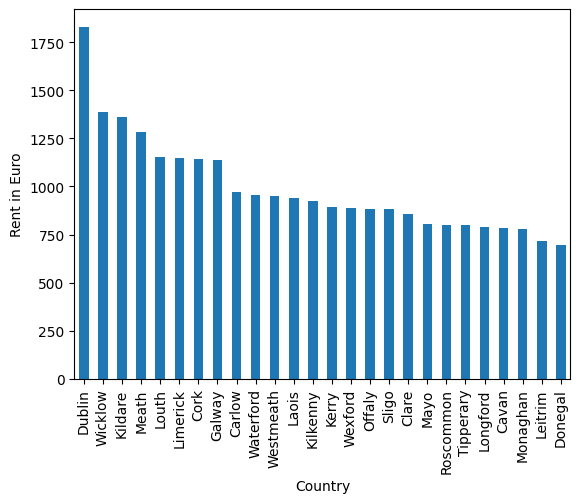

In [7]:
data.groupby('county')['rent_euro'].mean().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in Euro')

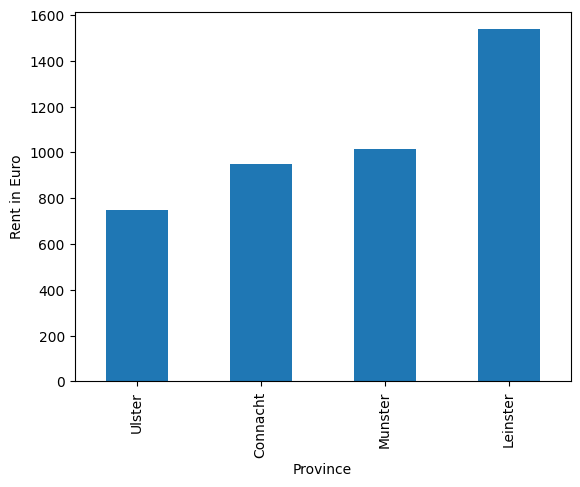

In [8]:
data.groupby('province')['rent_euro'].mean().sort_values(ascending = True).plot(kind = 'bar')
plt.xlabel('Province')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in Euro')

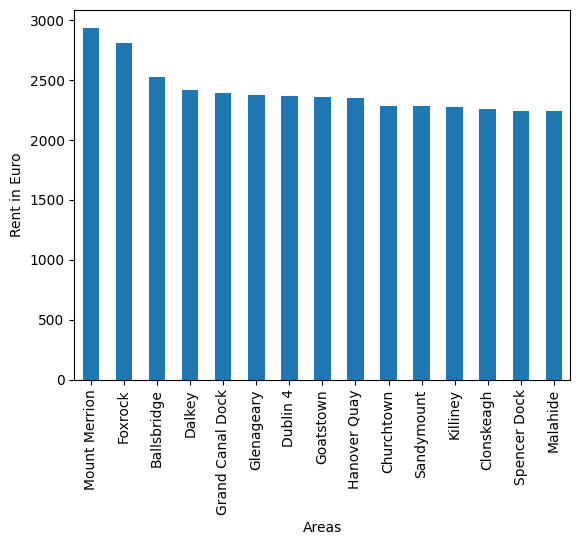

In [9]:
data.groupby('area')['rent_euro'].mean().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.xlabel('Areas')
plt.ylabel('Rent in Euro')

## Location Feature Validation

This step checks whether the `location` column is a composite feature formed using the `county` information.

Logic:
- For each row, the `county` value is searched inside the `location` string.
- If the county name is found inside the location text, it confirms redundancy.
- The percentage output shows how often `county` appears inside `location`.

This helps justify whether `location` is a derived/redundant feature and whether it can be removed during feature selection.


In [10]:
contains_county = data.apply(
    lambda row: str(row['county']).lower() in str(row['location']).lower(),
    axis=1
)

print("County present in location (%):", contains_county.mean() * 100)


County present in location (%): 100.0


Text(0, 0.5, 'Rent in Euro')

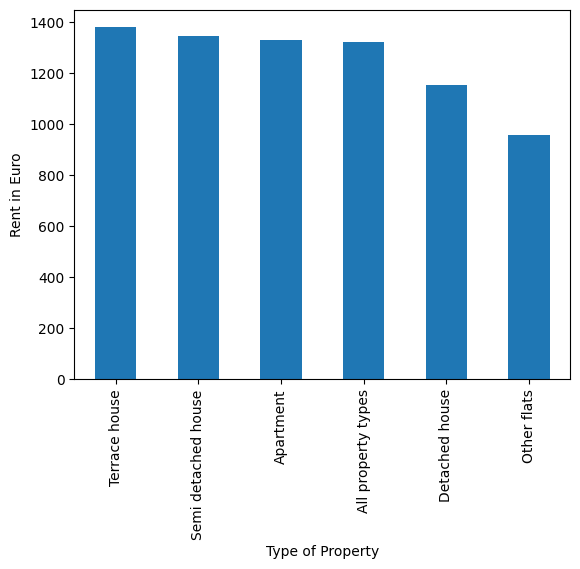

In [11]:
data.groupby('property_type')['rent_euro'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Type of Property')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in euro')

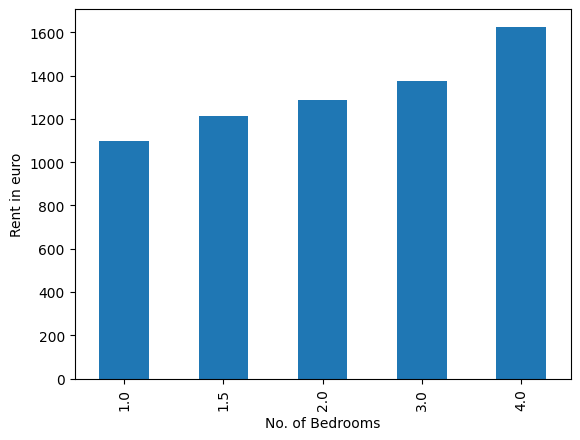

In [12]:
data.groupby('bedrooms_num')['rent_euro'].mean().sort_values(ascending = True).plot(kind = 'bar')
plt.xlabel('No. of Bedrooms')
plt.ylabel('Rent in euro')

Text(0, 0.5, 'Rent in Euro')

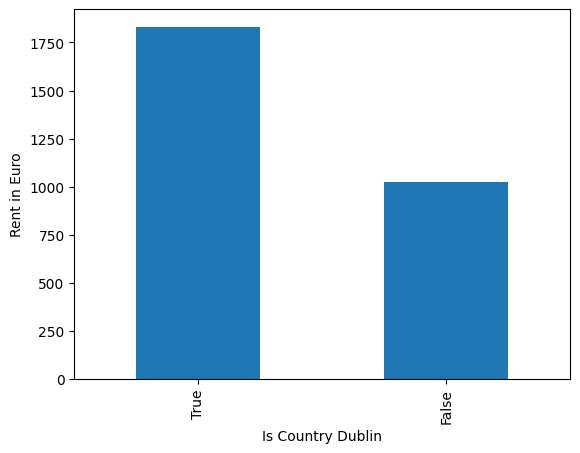

In [13]:
data.groupby('is_dublin')['rent_euro'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Is Country Dublin')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in Euro')

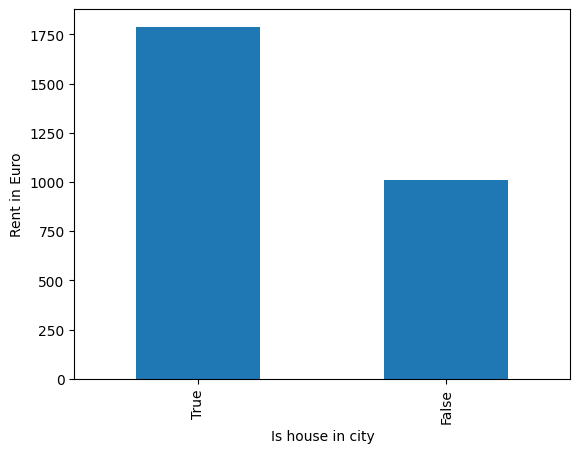

In [14]:
data.groupby('is_city')['rent_euro'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Is house in city')
plt.ylabel('Rent in Euro')

Text(0, 0.5, 'Rent in euro')

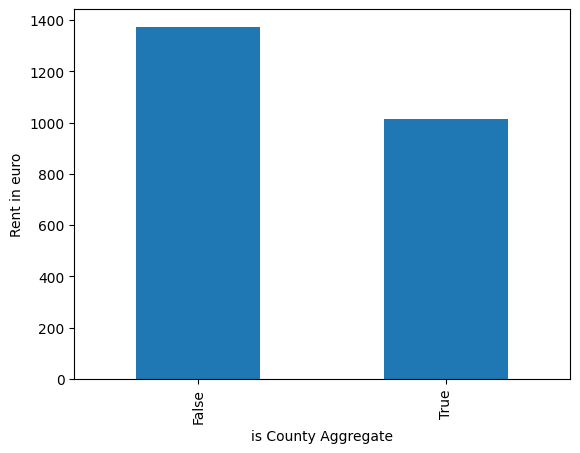

In [15]:
data.groupby('is_county_aggregate')['rent_euro'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('is County Aggregate')
plt.ylabel('Rent in euro')

## Feature Engineering

In this section:
- Unnecessary or redundant columns are removed
- Target variable (`rent_euro`) is separated
- Input features are prepared for model training

This step ensures clean input data for machine learning models.

In [16]:
input = data.drop(['half_year', 'location', 'bedrooms', 'constructed_half_year'], axis ='columns')
input.head()

,rent_euro,year,half,time_period,county,province,area,property_type,bedrooms_num,is_dublin,is_city,is_county_aggregate
0,835.90,2020,1,1,Carlow,Leinster,Carlow,All property types,NaN,False,False,True
1,860.74,2020,1,1,Carlow,Leinster,Carlow Town,All property types,NaN,False,False,False
2,910.91,2020,1,1,Carlow,Leinster,Graiguecullen,All property types,NaN,False,False,False
3,812.14,2020,1,1,Carlow,Leinster,Tullow,All property types,NaN,False,False,False
4,666.31,2020,1,1,Cavan,Ulster,Cavan,All property types,NaN,False,False,True


In [17]:
input = pd.get_dummies(input, columns = ['county', 'province', 'area', 'property_type'], drop_first = True)
input.head()

,rent_euro,year,half,time_period,bedrooms_num,is_dublin,is_city,is_county_aggregate,county_Cavan,county_Clare,...,area_Whitehall,area_Wicklow,area_Wicklow Town,area_Wilton,area_Youghal,property_type_Apartment,property_type_Detached house,property_type_Other flats,property_type_Semi detached house,property_type_Terrace house
0,835.90,2020,1,1,NaN,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,860.74,2020,1,1,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,910.91,2020,1,1,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,812.14,2020,1,1,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,666.31,2020,1,1,NaN,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
input['bedrooms_num'] = input['bedrooms_num'].fillna(input['bedrooms_num'].median())
input.head()

,rent_euro,year,half,time_period,bedrooms_num,is_dublin,is_city,is_county_aggregate,county_Cavan,county_Clare,...,area_Whitehall,area_Wicklow,area_Wicklow Town,area_Wilton,area_Youghal,property_type_Apartment,property_type_Detached house,property_type_Other flats,property_type_Semi detached house,property_type_Terrace house
0,835.90,2020,1,1,2.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,860.74,2020,1,1,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,910.91,2020,1,1,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,812.14,2020,1,1,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,666.31,2020,1,1,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
input = input.drop('rent_euro', axis = 'columns')
target = data['rent_euro']

## Train-Test Split

The dataset is split into:
- Training set
- Testing set

This is done to evaluate model performance on unseen data and avoid data leakage.

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(input, target, test_size = 0.2, random_state = 43)

## Cross Validation Strategy

TimeSeriesSplit is used instead of random K-Fold because the dataset contains **time-dependent features**.

This ensures:
- No future data leakage
- Proper chronological validation
- Realistic performance evaluation


In [21]:
tss = TimeSeriesSplit(n_splits = 10)

## Model Comparison Using Cross Validation

Two models are evaluated using TimeSeriesSplit cross-validation:
- Linear Regression
- Random Forest Regressor

Cross-validation helps in comparing model stability and generalization performance.


In [22]:
score1 = cross_val_score(LinearRegression(), X_train, Y_train, cv = tss)
print(score1.mean())
print(score1.std())

0.9006956125150355
0.00415023201794316


In [23]:
score2 = cross_val_score(RandomForestRegressor(n_estimators = 15), X_train, Y_train, cv = tss)
print(score2.mean())
print(score2.std())

0.9460544947416298
0.021357712229802633


## Final Model Selection

Based on cross-validation performance and evaluation metrics,  
**RandomForestRegressor** is selected as the final model for prediction.


In [24]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

## Model Prediction

The trained model is used to generate predictions on the test dataset.




In [25]:
Y_pred = model.predict(X_test)

In [26]:
model.score(X_test, Y_test)

0.9719551317330718

## Model Evaluation

The model is evaluated using:
- Mean Squared Error (MSE)
- R² Score (R-Squared)

These metrics are used to measure:
- Prediction error
- Model accuracy
- Generalization capability


In [27]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'M.S.E. :{mse}')
print(f'R2 Score : {r2}')

M.S.E. :7605.497766060543
R2 Score : 0.9719551317330718


In [ ]:
import joblib
joblib.dump(model, 'house-rent-model.pkl')

## Conclusion

This project demonstrates a complete machine learning pipeline including:
- Data analysis
- Feature understanding
- Feature engineering
- Model comparison
- Model selection
- Model evaluation

The RandomForestRegressor model shows strong performance on the Irish rent dataset, 
making it suitable for rental price prediction tasks.

This project is structured for:
- Academic evaluation
- Portfolio presentation
- GitHub showcasing
- Interview discussion
